In [3]:
!pip install langchain_groq

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.5/137.5 kB 7.7 MB/s eta 0:00:00


In [4]:
from getpass import getpass

from typing import List, Dict, Any, Optional, TypedDict
from langgraph.graph import StateGraph, START, END
from langchain_core.messages import HumanMessage

import networkx as nx
import matplotlib.pyplot as plt

import os
from google.colab import userdata
from IPython.display import Markdown, display, Image

In [5]:
from langchain_groq import ChatGroq
os.environ["GROQ_API_KEY"] = userdata.get("GROQ_API_KEY")

llm = ChatGroq(model_name = 'openai/gpt-oss-120b', temperature = 0)
display(Markdown(llm.invoke('what is the capital of india?').content))

The capital of India is **New Delhi**.

* reasoning
* memory
* tool
* environment




In [ ]:
class EmailState(TypedDict):
    emails: List[str]
    spam_flags: List[bool]
    categories: List[str]
    summaries: List[str]
    replies: List[str]
    reviewed_replies: List[str]

def read_emails(state: EmailState):
    print('READING emails...')
    return {"emails": state.get('emails', [])}

def spam_filter_node(state: EmailState):
    print('checking for spam...')

    emails= state['emails']
    classifications, spam_flags = [], []

    for email in emails:
        prompt = f"""
        classify the following email as 'spam' or 'legitimate'.
        email content: {email}
        """

        result = llm.invoke(prompt)
        classification = result.content.strip().lower()
        classifications.append(classification)
        spam_flags.append('Spam' if 'spam' in classification else 'legitimate')
    return {'classifications': classifications, 'spam_flags': spam_flags}

def categorize_emails(state: EmailState):
    print('CATEGORIZING emails...')
    emails = state['emails']
    spam_flags, categories = state['spam_flags'], []
    for email, spam_flag in zip(emails, spam_flags):
        if spam_flag == 'Spam':
            categories.append('Spam')
        elif 'urgent' in email.lower() or 'today' in email.lower():
            categories.append('Very Urgent')
        elif 'deadline' in email.lower() or 'tomorrow' in email.lower():
            categories.append('Urgent')
        else:
            categories.append('Normal')
    return {'categories': categories}

def summarize_emails(state: EmailState):
    print('SUMMARIZING emails...')
    summaries = []
    for email, spam_flag in zip(state['emails'], state['spam_flags']):
        if spam_flag == 'Spam':
            summaries.append('Skipped (Spam)')
        else:
            prompt = f"summarize this email briefly: \n\n {email}"
            result = llm.invoke(prompt)
            summaries.append(result.content)

    return {'summaries': summaries}

def draft_replies(state: EmailState):
    print('DRAFTING replies...')
    replies = []
    for summary, category in zip(state['summaries'], state['categories']):
        if category == 'Spam':
            replies.append('Skipped (spam)')
            continue
        urgency_tone = {
            'Very Urgent': 'Respond immediately with confirmation',
            'Urgent' : "Respond promptly acknowledging the task",
            "Normal": 'Respond politely confirming'
        }

        prompt = f"Write a short reply for this email summary in tone: {urgency_tone[category]} \n\n summary: {summary}"
        result = llm.invoke(prompt)
        replies.append(result.content)

    return {"replies": replies}

def review_replies(state: EmailState):
    print('REVIEWING...')
    reviewed = []
    for reply, category in zip(state['replies'], state['categories']):
        if category == 'Spam':
            reviewed.append('Skipped (spam)')
        else: reviewed.append(reply)
    return {"reviewed_replies": reviewed}

def send_emails(state: EmailState):
    print('SENDING...')
    for reply, category in zip(state['reviewed_replies'], state['categories']):
        if category != 'Spam':
            print(f'\n({category}) -> {reply}')
    return {}

def handle_spam(state: EmailState):
    print('SPAM DETECTED')
    return {}

def route_after_spam_check(state: EmailState):
    if all(flag == 'Spam' for flag in state['spam_flags']):
        return 'handle spam'
    return 'categorize'

In [ ]:
graph = StateGraph(EmailState)

graph.add_node('read_emails', read_emails)
graph.add_node('spam_filter', spam_filter_node)
graph.add_node('categorize_emails', categorize_emails)
graph.add_node('summarize_emails', summarize_emails)
graph.add_node('draft_replies', draft_replies)
graph.add_node('review_replies', review_replies)
graph.add_node('send_emails', send_emails)
graph.add_node('handle_spam', handle_spam)

graph.add_edge(START, 'read_emails')
graph.add_edge('read_emails', 'spam_filter')
graph.add_conditional_edges(
    'spam_filter', route_after_spam_check, {
        'handle spam' : 'handle_spam',
        'categorize' : 'categorize_emails'
    }
)
graph.add_edge('categorize_emails', 'summarize_emails')
graph.add_edge('summarize_emails', 'draft_replies')
graph.add_edge('draft_replies', 'review_replies')
graph.add_edge('review_replies', 'send_emails')
graph.add_edge('send_emails', END)
graph.add_edge('handle_spam', END)

compiled_graph = graph.compile()

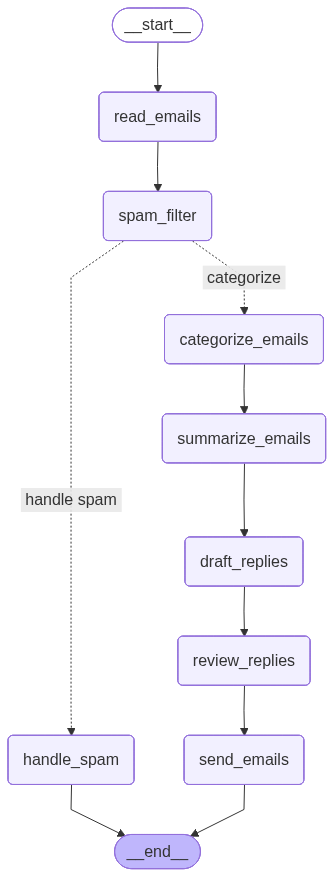

In [39]:
display(Image(compiled_graph.get_graph().draw_mermaid_png()))

In [41]:
sample_emails  = [
    'the final report must be submitted by 5PM today.',
    'Congratulations! you won a lottery of $10000',
    'reminder: team meeting tomorrow moring 10AM',
    'hey, how are you? call me whe you are free'
]

initial_state = {'emails': sample_emails}
final_state = compiled_graph.invoke(initial_state)

READING emails...
checking for spam...
CATEGORIZING emails...
SUMMARIZING emails...
DRAFTING replies...
REVIEWING...
SENDING...

(Very Urgent) -> Confirmed – I will submit the final report by 5 PM today.

(Urgent) -> Got it—thanks for the reminder. I’ll be there at 10 AM tomorrow.

(Normal) -> Dear [Name],

Thank you for your message. I’ll give you a call as soon as I’m available.

Best regards,  
[Your Name]
